<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune TrOCR on the IAM Handwriting Database

In this notebook, we are going to fine-tune a pre-trained TrOCR model on the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database), a collection of annotated images of handwritten text.

We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text.

This figure gives a good overview of the model (from the original paper):

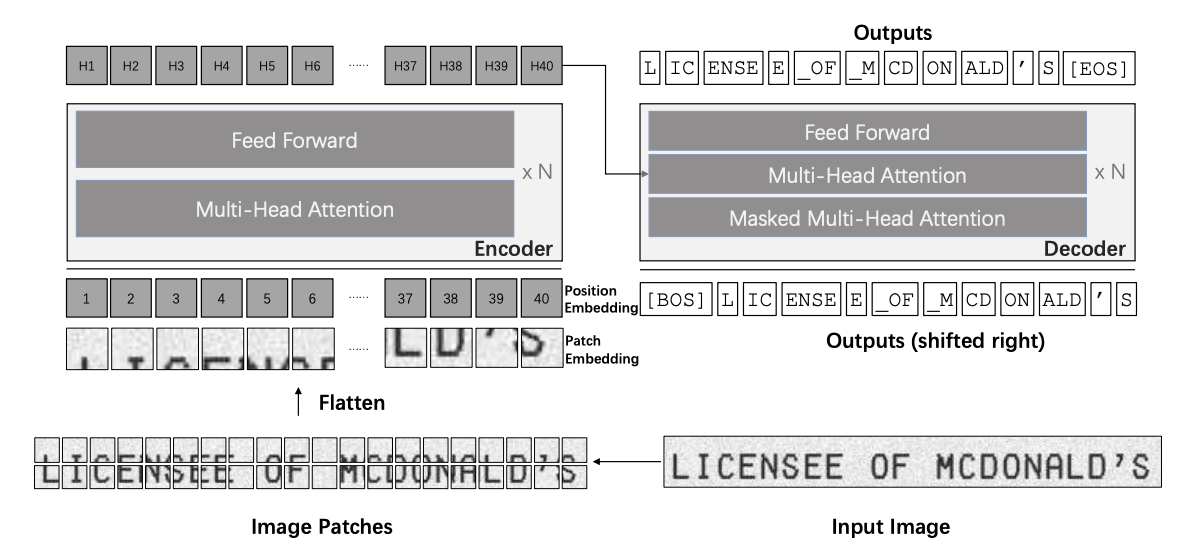

* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html


Note that Patrick also wrote a very good [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder) on warm-starting encoder-decoder models (which is what the TrOCR authors did). This blog post was very helpful for me to create this notebook.

We will fine-tune the model using native PyTorch.



## Set-up environment

First, let's install the required libraries:
* Transformers (for the TrOCR model)
* Datasets & Jiwer (for the evaluation metric)

We will not be using HuggingFace Datasets in this notebook for data preprocessing, we will just create a good old basic PyTorch Dataset.

In [ ]:
!pip install -q transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/converting-handwritten-equations-to-latex-code.zip

Streaming output truncated to the last 5000 lines.
  inflating: col_774_A4_2023/SyntheticData/images/9815fbde36.png  
  inflating: col_774_A4_2023/SyntheticData/images/981bae7fac.png  
  inflating: col_774_A4_2023/SyntheticData/images/98214e296a.png  
  inflating: col_774_A4_2023/SyntheticData/images/98217b6ee0.png  
  inflating: col_774_A4_2023/SyntheticData/images/982488de16.png  
  inflating: col_774_A4_2023/SyntheticData/images/9825799fb5.png  
  inflating: col_774_A4_2023/SyntheticData/images/982a3158be.png  
  inflating: col_774_A4_2023/SyntheticData/images/982d263ca2.png  
  inflating: col_774_A4_2023/SyntheticData/images/982d34dcfe.png  
  inflating: col_774_A4_2023/SyntheticData/images/982d8aa2c6.png  
  inflating: col_774_A4_2023/SyntheticData/images/9835a92140.png  
  inflating: col_774_A4_2023/SyntheticData/images/983c3a9b77.png  
  inflating: col_774_A4_2023/SyntheticData/images/983ec3fa69.png  
  inflating: col_774_A4_2023/SyntheticData/images/9844de47e7.png  
  inflating

In [ ]:
!ls drive/MyDrive/

'Colab Notebooks'   converting-handwritten-equations-to-latex-code.zip


In [ ]:
!pip install -q datasets jiwer

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr).

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [ ]:
import pandas as pd

train_df = pd.read_csv('col_774_A4_2023/HandwrittenData/train_hw.csv')
train_df.rename(columns={'image': 'file_name', 'formula': 'text'}, inplace=True)
# del df[2]
# print(df)
train_df.head()
# some file names end with jp instead of jpg, let's fix this
# df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)

,file_name,text
0,MfrDB3500.png,$ { ( 1 + x ) ^ { r } } \geq 1 + r x $
1,formulaire031-equation022.png,$ v ( a + i b ) = a ^ 2 + b ^ 2 $
2,200923-1251-167.png,$ { \mbox { F } H } $
3,rit_4220_4.png,$ - \frac { h ^ { 2 } _ { 3 } + h ^ { 2 } _ { ...
4,123_em_370.png,$ V = \int _ 0 ^ { x _ 1 } 2 S \mathrm d x $


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [ ]:
# import pandas as pd

test_df = pd.read_csv('col_774_A4_2023/HandwrittenData/val_hw.csv')
test_df.rename(columns={'image': 'file_name', 'formula': 'text'}, inplace=True)
# del df[2]
# print(df)
test_df.head()
# some file names end with jp instead of jpg, let's fix this
# df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)

,file_name,text
0,formulaire014-equation025.png,$ 1 0 7 + ( 8 2 \div 1 0 8 ) \neq - 9 0 $
1,TrainData1_6_sub_9.png,$ \sin ^ { 2 } \theta + \cos ^ { 2 } \theta = 1 $
2,RIT_2014_168.png,$ 2 \pi n ! e = 2 \pi n ! + \frac { 2 \pi n ! ...
3,2009212-1031-111.png,$ \sum _ { { T \geq g } } { 8 . 2 } $
4,formulaire021-equation041.png,$ r = r ( \theta ) $


In [ ]:
# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df, test_size=0.2)
# # we reset the indices to start from zero
# train_df.reset_index(drop=True, inplace=True)
# test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='col_774_A4_2023/HandwrittenData/images/train/',
                           df=train_df,
                           processor=processor,
                           max_target_length = 128)
eval_dataset = IAMDataset(root_dir='col_774_A4_2023/HandwrittenData/images/train/',
                           df=test_df,
                           processor=processor,
                          max_target_length = 128)

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 9000
Number of validation examples: 1000


Let's verify an example from the training dataset:

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

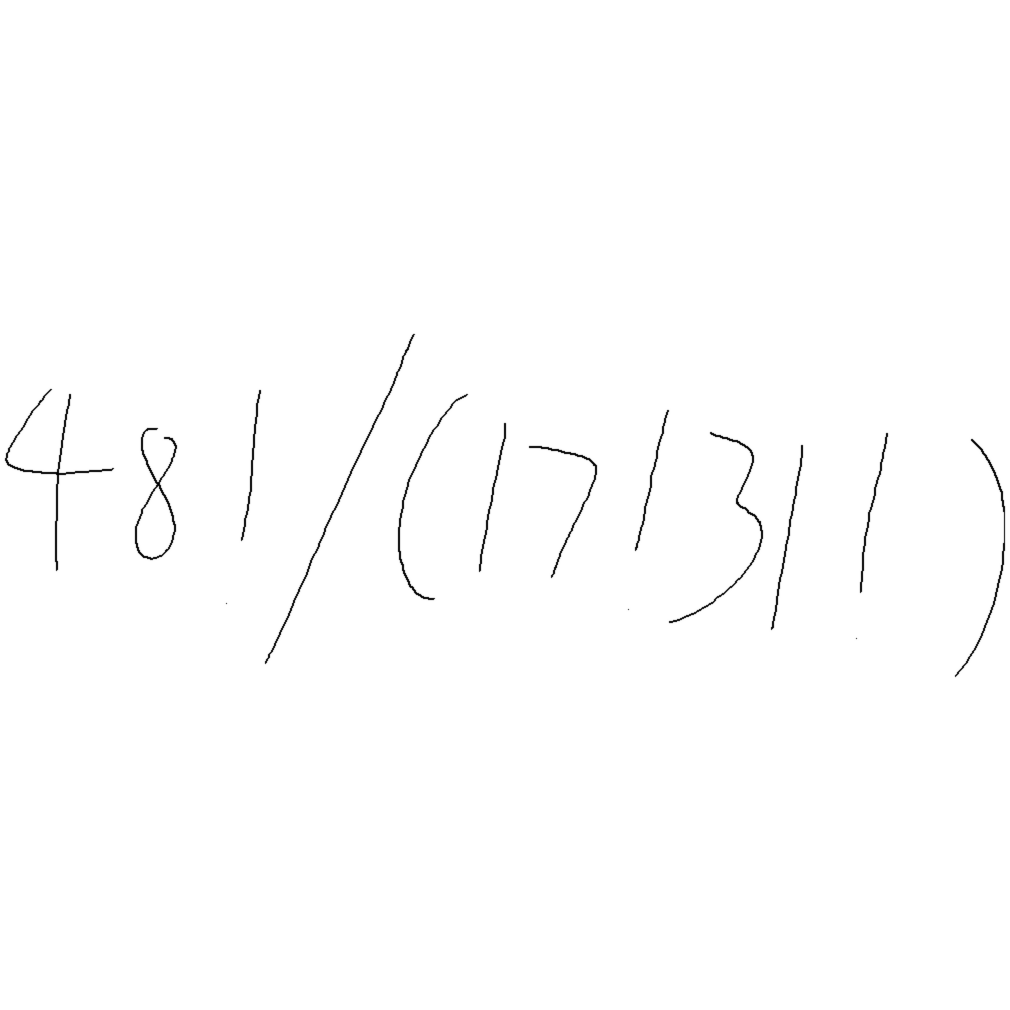

In [ ]:
image = Image.open(eval_dataset.root_dir + train_df['file_name'][5]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

$ { ( 1 + x ) ^ { r } } \geq 1 + r x $


Let's create corresponding dataloaders:

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=5)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [ ]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [ ]:
model.config.decoder.vocab_size

50265

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 1
model.config.length_penalty = 1.5
model.config.num_beams = 2

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [ ]:
import nltk

def sbleu(GT,PRED):
    score = 0
    for i in range(len(GT)):
        Lgt = len(GT[i].split(' '))
        if Lgt > 4 :
            cscore = nltk.translate.bleu_score.sentence_bleu([GT[i].split(' ')],PRED[i].split(' '),weights=(0.25,0.25,0.25,0.25),smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
        else:
            weight_lst = tuple([1.0/Lgt]*Lgt)
            cscore = nltk.translate.bleu_score.sentence_bleu([GT[i].split(' ')],PRED[i].split(' '),weights=weight_lst,smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
        score += cscore
    return score/(len(GT))

In [ ]:
ground_truths = ['$ \\mbox { j B d } $',
                 '$ s _ 0 = 2 $',
                 '$ \\lim _ { y \\to \\infty } y \\sin ( \\frac { c } { y } ) = c $',
                 '$ \\cos a = 0 . 2 $',
                 '$ M ( R ) $',
                 '$ { \\cdots + { \\cos } ^ { 8 } H } $',
                 '$ \\sum _ { { X \\gt a } } { { \\alpha - c } } $',
                 '$ x ( \\theta ) = a \\sin ( \\theta ) $',
                 '$ \\sin \\phi = 2 \\sin \\frac { \\phi } { 2 } \\cos \\frac { \\phi } { 2 } $',
                 '$ \\sum _ { n = 1 } ^ { \\infty } { ( \\frac { \\sum _ { i = 1 } ^ { n } a _ { i } } { n } ) ^ { p } } \\lt { ( \\frac { p } { p - 1 } ) ^ { p } } \\sum _ { n = 1 } ^ { \\infty } { a _ { n } ^ { p } } $']


predictions = ground_truths
sbleu(ground_truths, predictions)

1.0

In [ ]:
predictions = ['$ { \\sqrt { 3 } } $',
             '$ S = 2 $',
             '$ 1 . 4 _ 0 - \\frac { 2 } { 3 } \\times ( 2 0 ) = 5 $',
             '$ a _ 0 = a _ 1 = a _ 2 $',
             '$ M ( r ) $',
             '$ { \\cdots + c . 6 } $',
             '$ \\sum _ { a , b } ^ { - 1 } a $',
             '$ x ( - a ) = - b ( x ^ { 0 } ) $',
             '$ h = x = 3 x + 4 y _ 2 + \\frac { a } { 2 } $',
             '$ \\sum _ { k = 1 } ^ { n } { 3 } { ( 1 _ { n } ) ^ { 2 } } \\leq \\sum _ { k = 1 } ^ { n } a _ { k } $']

sbleu(ground_truths, predictions)

0.16469372937379761

In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-20-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [ ]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(10):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        if k == 'labels' or k == 'pixel_values':
          batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
   torch.save(model,'./drive/MyDrive/mkc_1.pth')
   print("Model Saved")
   # evaluate
  #  model.eval()
  #  valid_cer = 0.0
  #  with torch.no_grad():
  #    for batch in tqdm(eval_dataloader):
  #      # run batch generation
  #      outputs = model.generate(batch["pixel_values"].to(device))
  #      generated_text = processor.batch_decode(outputs, skip_special_tokens=True)
  #      # compute metrics
  #     #  bleu = sbleu(GT=batch["text"],PRED=generated_text)
  #     #  valid_bleu += bleu

  #      cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
  #      valid_cer += cer

  #  print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1800 [00:00<?, ?it/s]

Loss after epoch 0: 1.4918208491139942
Model Saved


  0%|          | 0/1800 [00:00<?, ?it/s]

Loss after epoch 1: 0.8157057527287139
Model Saved


  0%|          | 0/1800 [00:00<?, ?it/s]

Loss after epoch 2: 0.6359976409334276
Model Saved


  0%|          | 0/1800 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model.save_pretrained("./drive/MyDrive/")

NameError: ignored

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [ ]:
outputs = model.generate(batch["pixel_values"].to(device))


NameError: ignored

In [ ]:
test_output = pd.read_csv('./sample_sub.csv')
test_output.rename(columns={'image': 'file_name', 'formula': 'text'}, inplace=True)
# del df[2]
# print(df)
test_output.head()

,file_name,text
0,81-1312-200924.png,0
1,1698881946969636953.png,0
2,rM3DfB510.png,0
3,em_UN_103_56.png,0
4,1698881946969702936.png,0


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
def pred(file,processor:TrOCRProcessor,model):
    image = Image.open(file).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values.to('cuda')
    generated_ids = model.generate(pixel_values, max_length = 60)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    # g = generated_text.split()

    return generated_text

In [ ]:
root_dir = './col_774_A4_2023/HandwrittenData/images/test/'

In [ ]:
for o in range(len(output_)):
  if output_[o] == '' or output_[o] == "" or output_[o] == ' ' or output_[o] == " ":
    output_[o] = "$ $"

In [46]:
import numpy as np
arr = test_output.to_numpy()
x = np.column_stack((arr[:,0],np.array(output_[:-2])))

In [49]:
DF = pd.DataFrame(x)
DF.to_csv("./data3.csv",index=False)

In [ ]:
output_ = [""]*(len(test_output)+2)
for i in range(len(test_output)):
    output_[i] = pred(root_dir+test_output['file_name'][i],processor=processor,model=model)

In [ ]:
# print(outputs)
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]

tensor([[0, 2]], device='cuda:0')


In [ ]:
print(generated_text)

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  if k == 'pixel_values':
    print(type(v))
    outputs = model.generate(v.unsqueeze(0).to(device))
    generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    print(outputs)
  if k == 'labels':
    print(k,v)
    generated_text_2 = processor.batch_decode(v, skip_special_tokens=True)[0]
    # print(generated_text)
  print(k,v)
# outputs = model.generate(batch["pixel_values"].to(device))



print(sbleu(GT=generated_text,PRED=generated_text_2))


<class 'torch.Tensor'>
tensor([[0, 2]], device='cuda:0')
pixel_values tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
labels tensor([    0,  1629, 25522,    36,   112,  2055,  3023,  4839, 37249, 25522,
          910, 35524, 35524, 44128,  1899,  1343,   112,  2

OverflowError: ignored